Import libraries and loading data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [44]:
data = pd.read_csv('PM2.5_Air_Pollution_Dataset.csv')
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


<h3><b>Step.1 - Data Preprocessing</b></h3>

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [46]:
# check for duplicated values and null values
print('Duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Duplicated values in our data ? : False

The total number of null values in each colum:


No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [47]:
# find the most appearing wind direction value
data.cbwd.mode()

0    SE
Name: cbwd, dtype: object

In [48]:
# fill in the missing
data.fillna(value=data.mean(),inplace=True)
data.cbwd.fillna(value='NE',inplace=True)
data.isnull().any()

No       False
year     False
month    False
day      False
hour     False
pm2.5    False
DEWP     False
TEMP     False
PRES     False
cbwd     False
Iws      False
Is       False
Ir       False
dtype: bool

In [49]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010-01-01 00:00:00,1,2010,1,1,0,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01 01:00:00,2,2010,1,1,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01 02:00:00,3,2010,1,1,2,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01 03:00:00,4,2010,1,1,3,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01 04:00:00,5,2010,1,1,4,98.613215,-20,-12.0,1018.0,NW,12.97,0,0


<h3><b>Step.2 - Exploratory Data Analysis</b></h3>

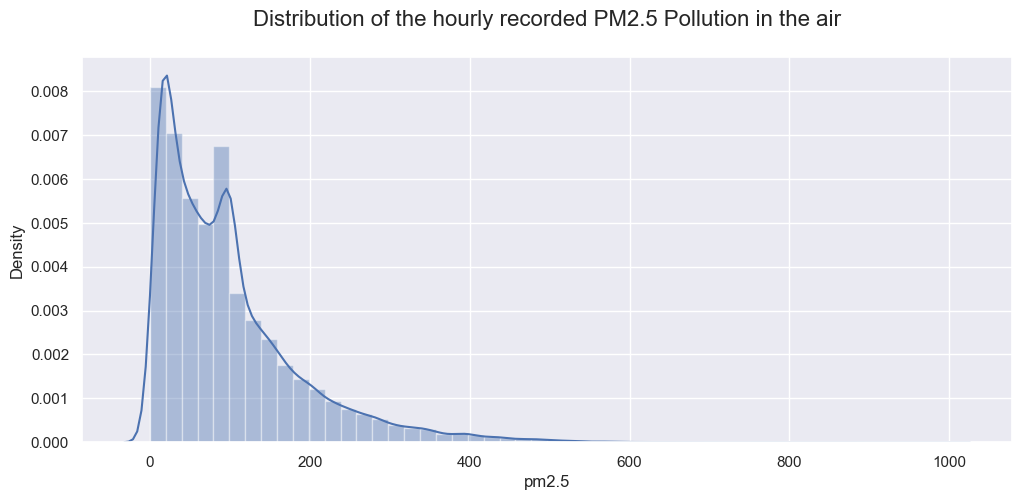

In [50]:
plt.figure(figsize=(12,5))
sns.distplot(data['pm2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 Pollution in the air\n', fontsize=16)
plt.show()

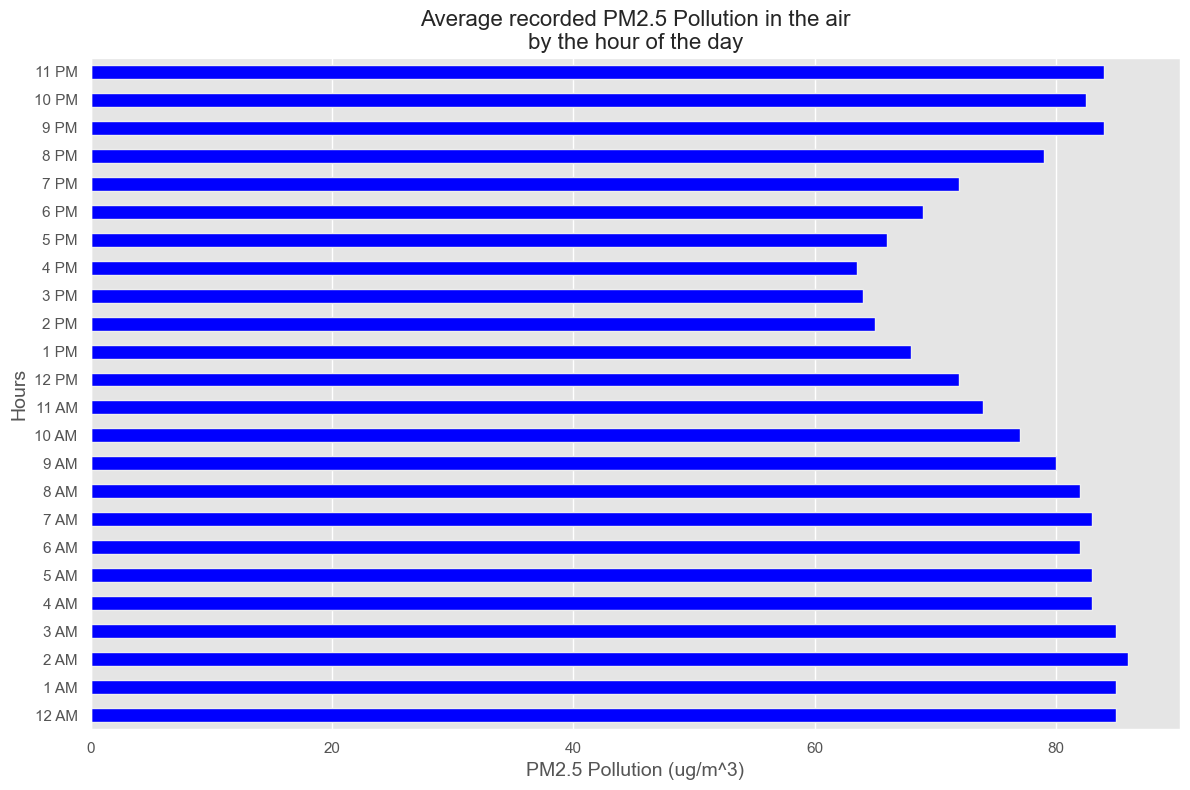

In [51]:
hourly_data = data[['hour','pm2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=1, color='blue')
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 Pollution (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 Pollution in the air\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

<h3><b>Step.3 - Model Training and Evaluation</b></h3>
<br>
<h5><b>check for multicollinearity among variables and fit a regression model using statsmodels</b></h5>

In [52]:
cols_to_drop = ['date','year','month','day','hour','cbwd']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    35104.807313
No           1.016148
pm2.5        1.290501
DEWP         4.415586
TEMP         5.309791
PRES         3.533140
Iws          1.159637
Is           1.016473
Ir           1.043993
dtype: float64

In [53]:
# we can see that TEMP (temperature) and DEWP (dewpoint) are highly correlated as the VIF value is 
# greater than 5. As a result, we get rid of one of those features and probably the one that has the 
# lowest correlation with the dependent variable.
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    33503.009756
No           1.015725
pm2.5        1.126324
TEMP         3.388331
PRES         3.357370
Iws          1.104484
Is           1.009511
Ir           1.011694
dtype: float64

In [54]:
newdata.columns = ['pm2_5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['pm2_5'] = np.log(newdata['pm2_5'])

In [55]:
# fit the regression model
#mul_reg = formula.ols(formula='PM2_5 ~ PM10 + SO2 + NO2 + CO + O3 + TEMP + PRES + RAIN + WSPM', data=newdata).fit()
mul_reg = formula.ols(formula = 'pm2_5 ~ DEWP + TEMP + PRES + Iws + Is + Ir', data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pm2_5   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     255.6
Date:                Mon, 26 Jun 2023   Prob (F-statistic):          1.19e-322
Time:                        09:54:30   Log-Likelihood:                -61397.
No. Observations:               43824   AIC:                         1.228e+05
Df Residuals:                   43817   BIC:                         1.229e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3345      0.857     -6.224      0.000      -7.015      -3.655
DEWP           0.0002   5.54e-05      3.681      0.000    9.54e-05       0.000
TEMP           0.0216      0.001     30.719      0.000       0.020       0.023
PRES           0.0145      0.001     17.387      0.000       0.013       0.016
Iws           -0.0009   9.84e-05     -8.650      0.000      -0.001      -0.001
Is            -0.0694      0.006    -11.193      0.000      -0.082      -0.057
Ir            -0.0038      0.003     -1.136      0.256      -0.010       0.003
==============================================================================
Omnibus:                    15424.138   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58362.301
Skew:                          -1.751   Prob(JB):                         0.00
Kurtosis:                       7.439   Cond. No.                     1.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>The OLS model from statsmodels gives us an accuracy of 71% (0.712) which is not satisfactory for prediction. So we move on to fit a linear regression model from the scikit-learn library.</p>
<br>
<h5><b>fitting a linear regression model with sklearn.linear_model.L inearRegression()</b></h5>

In [56]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('pm2_5',axis=1)
y = newdata['pm2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,DEWP,TEMP,PRES,Iws,Is,Ir
0,0.0,-1.922250,0.443328,-0.441894,-0.069353,-0.137667
1,0.0,-2.004228,0.345943,-0.379306,-0.069353,-0.137667
2,0.0,-1.922250,0.248559,-0.343514,-0.069353,-0.137667
3,0.0,-2.168183,0.248559,-0.280926,-0.069353,-0.137667
4,0.0,-2.004228,0.151174,-0.218339,-0.069353,-0.137667


In [57]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [58]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Model accuracy: {}'.format(accuracy))

Mean Squared Error: 0.9399424788164522

Model accuracy: 0.030622854762158203


<p>The model accuracy for the LinearRegression() is no better than that of the statsmodels. They all give the same accuracy is not better for making predictions. We now move on to fit other models by using the ensemble methods</p>
<br>
<br>
<h3><b>Ensemble methods</b></h3>
<p>For ensemble methods (DecisionTreeRegressor,RandomForestRegressor,and GradientBoostingRegressor),we include the pressure and rain features and we won't scale the predictor variables,neither would we log transform the outcome variable. At this part, model fitting and hyper-parameter tunning will be done at the same time. Instead of fitting the model with single parameters, we will straight away perform the grid search with multiple values for a parameter and find the best parameters for fitting the model on our data to get a satisfactory accuracy.</p>

In [59]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('pm2.5',axis=1)
y = ensemble_data['pm2.5']

In [60]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

### DecisionTreeRegressor
we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [61]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [62]:
tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Model accuracy: {}'.format(tree_accuracy))

Root Mean Squared Error: 75.03860689506689

Model accuracy: 0.28681165738566516


In [63]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [64]:
tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Root Mean Squared Error: 70.71491481087173

Overall model accuracy: 0.3666310695629075


### RandomForestRegressor

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [65]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                      min_samples_split=7)

In [66]:
forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Root Mean Squared Error: 68.59776447732548

Overall model accuracy: 0.40398850481922577


In [67]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [68]:
forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Root Mean Squared Error: 68.60299886462064

Overall model accuracy: 0.4038975434285984


### GradientBoostingRegressor

we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error.

In [69]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [70]:
gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Root Mean Squared Error: 43.02974545507564

Overall model accuracy: 0.7654841153660379


In [71]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [72]:
gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Root Mean Squared Error: 31.470670258266104

Overall model accuracy: 0.8745569237937179


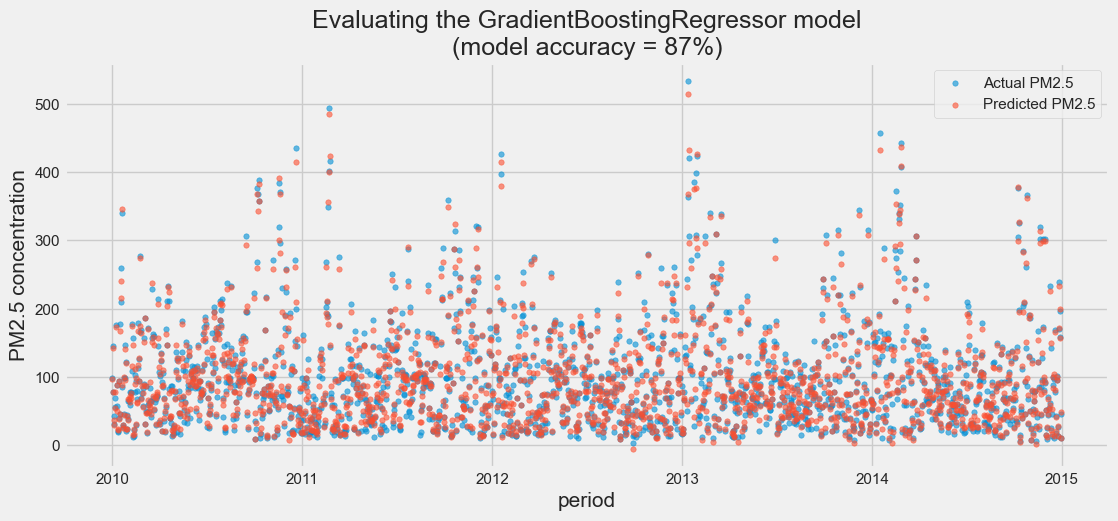

In [73]:
# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5 
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 87%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()